### Imports and Setups

In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    f1_score, 
    roc_auc_score, 
    precision_score, 
    recall_score
)
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from os.path import join
import seaborn as sns
import pandas as pd

from build_features import load_moons, load_concentric
from utils import euclidian, plot_plain_separator
from model_selection import run_model_selection, load_model

use_tunned = False

### Load dataframe

Generate a sample dataset with few superposition for test. This dataset is supposed to be the correct one, without error on label acquisition.

In [2]:
x1, x2, y1, y2 = load_moons(noise=0.2, samples=2000)
x_test = np.vstack([x1, x2])
y_test = np.concatenate([y1, y2])
data_test = pd.DataFrame(x_test, columns=['x1', 'x2'])
data_test['class'] = y_test

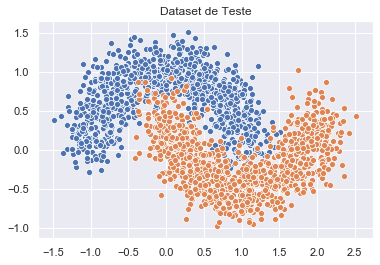

In [3]:
sns.set()
ax_1 = sns.scatterplot(x=x_test[y_test == 0,0], y=x_test[y_test == 0,1])
ax_2 = sns.scatterplot(x=x_test[y_test == 1,0], y=x_test[y_test == 1,1])
plt.title("Dataset de Teste")
plt.show()

Generate a noisy dataset for training. The noise is to simmulate an error on the label acquisition process.

In [4]:
x1, x2, y1, y2 = load_moons(noise=0.35, samples=200)
x_train = np.vstack([x1, x2])
y_train = np.concatenate([y1, y2])

data_train = pd.DataFrame(x_train, columns=['x1', 'x2'])
data_train['class'] = y_train

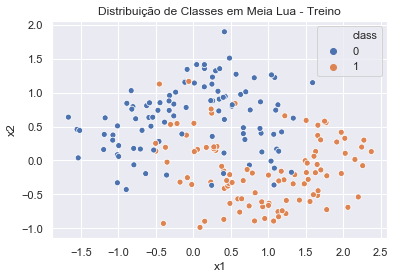

In [5]:
sns.set()
sns.scatterplot(x='x1', y='x2', hue='class', data=data_train)
plt.title('Distribuição de Classes em Meia Lua - Treino')
plt.show()

### (Optional) Run hyperparameter tuning using grid search

In [6]:
if False:
    cls = run_model_selection(x_train, y_train, verbose=True)
    best = cls.best_params_
    use_tunned = True

## Run training on noisy dataset without relabeling

In [ ]:
if use_tunned:
    mlp = load_model(params=best)
else:
    mlp = load_model(verbose=True)

mlp.fit(x_train, y_train)


In [8]:
print(f'Accuracy = {mlp.score(x_train, y_train)}')
predicted = mlp.predict(x_train)
print(classification_report(y_train, predicted))

Accuracy = 0.98
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       100
           1       0.97      0.99      0.98       100

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



In [9]:
print(mlp.score(x_test, y_test))
predicted = mlp.predict(x_test)
print(classification_report(y_test, predicted))

0.9205
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1000
           1       0.93      0.92      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



In [10]:
f1 = f1_score(y_pred=predicted, y_true=y_test)
print(f1)

0.9200603318250377


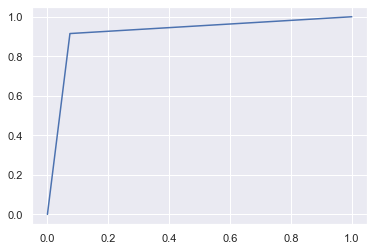

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, predicted)
sns.set()
sns.lineplot(x=fpr, y=tpr)

In [12]:
print(np.linalg.norm(mlp.coefs_[0]), np.linalg.norm(mlp.coefs_[1]))

43.04631303474426 40.007825374594724


## Generate hyperplane with noisy dataset

C:\Users\victo\Google Drive\Mestrado\Redes Neurais\Trabalhos\Artigo_03\code\notebooks\utils.py:45: UserWarning: No contour levels were found within the data range.
  plt.contour(x1, x2, z, levels=[0], colors=('cyan',), linewidths=(2.5,))


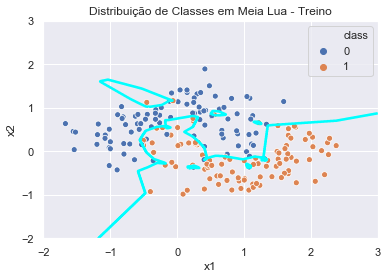

In [13]:
sns.set()
sns.scatterplot(x='x1', y='x2', hue='class', data=data_train)
plt.title('Distribuição de Classes em Meia Lua - Treino')    
plot_plain_separator(mlp, x_train, save=False, grid_range=(-2, 3))

plt.show()

C:\Users\victo\Google Drive\Mestrado\Redes Neurais\Trabalhos\Artigo_03\code\notebooks\utils.py:45: UserWarning: No contour levels were found within the data range.
  plt.contour(x1, x2, z, levels=[0], colors=('cyan',), linewidths=(2.5,))


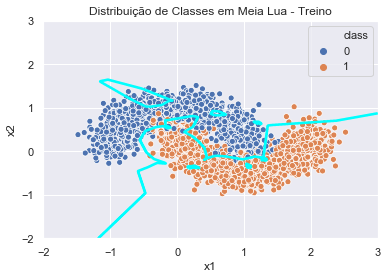

In [14]:
sns.set()
sns.scatterplot(x='x1', y='x2', hue='class', data=data_test)
plt.title('Distribuição de Classes em Meia Lua - Treino')    
plot_plain_separator(mlp, x_train, save=False, grid_range=(-2, 3))

plt.show()

## Run relabeling

In [15]:
def norm_distance(dist):
    return 1 - normalize(dist).ravel()

In [16]:
knn = KNeighborsClassifier(n_neighbors=5, weights=norm_distance)

In [17]:
y_classes = []
for index in range(x_train.shape[0]):
    x_t = np.delete(x_train, index, 0)
    y_t = np.delete(y_train, index, 0)
    knn.fit(x_t, y_t)
    y_classes.append(knn.predict([x_train[index]])[0])

errors = y_train - y_classes

wrong_classes = np.where(errors != 0)[0]

print('Fixing training samples with adjustment')
y_train_2 = y_train.copy()

for i in wrong_classes:
    y_train_2[i] = 0 if y_train[i] == 1 else 1

Fixing training samples with adjustment


## Run training on relabeled dataset

In [ ]:
if use_tunned:
    mlp = clf
else:
    mlp = load_model(verbose = True)

mlp.fit(x_train, y_train_2)


In [19]:
print(f'Accuracy = {mlp.score(x_train, y_train)}')
predicted = mlp.predict(x_train)
print(classification_report(y_train, predicted))

Accuracy = 0.895
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       100
           1       0.89      0.90      0.90       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.89       200
weighted avg       0.90      0.90      0.89       200



In [20]:
mlp.score(x_test, y_test)
predicted = mlp.predict(x_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1000
           1       0.96      0.96      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [21]:
f1 = f1_score(y_pred=predicted, y_true=y_test)
print(f1)

0.9591633466135459


In [22]:
print(np.linalg.norm(mlp.coefs_[0]), np.linalg.norm(mlp.coefs_[1]))

18.856025888871592 22.911709901821872


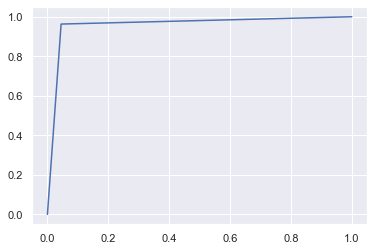

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, predicted)
sns.set()
sns.lineplot(x=fpr, y=tpr)

## Generate hyperplane with relabeled dataset

C:\Users\victo\Google Drive\Mestrado\Redes Neurais\Trabalhos\Artigo_03\code\notebooks\utils.py:45: UserWarning: No contour levels were found within the data range.
  plt.contour(x1, x2, z, levels=[0], colors=('cyan',), linewidths=(2.5,))


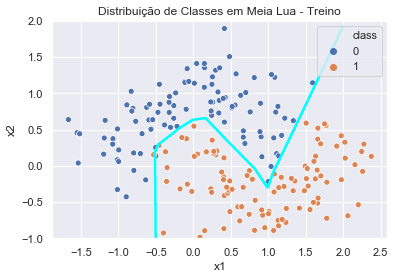

In [24]:
data_train_2 = pd.DataFrame(x_train, columns=['x1', 'x2'])
data_train_2['class'] = y_train_2

sns.set()
sns.scatterplot(x='x1', y='x2', hue='class', data=data_train_2)
plt.title('Distribuição de Classes em Meia Lua - Treino')    
plot_plain_separator(mlp, x_train, save=False, grid_range=(-1, 2))

plt.show()

C:\Users\victo\Google Drive\Mestrado\Redes Neurais\Trabalhos\Artigo_03\code\notebooks\utils.py:45: UserWarning: No contour levels were found within the data range.
  plt.contour(x1, x2, z, levels=[0], colors=('cyan',), linewidths=(2.5,))


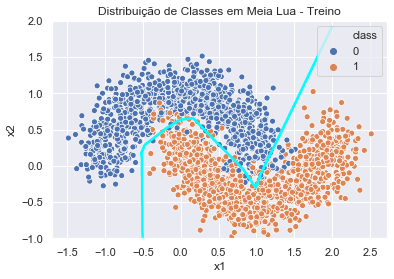

In [25]:
sns.set()
sns.scatterplot(x='x1', y='x2', hue='class', data=data_test)
plt.title('Distribuição de Classes em Meia Lua - Treino')    
plot_plain_separator(mlp, x_train, save=False, grid_range=(-1, 2))

plt.show()